## Project Links
GDP Data: https://databank.worldbank.org/reports.aspx?source=2&type=metadata&series=NY.GDP.MKTP.CD <br>
CO2 Emission from Fuel Combustion (IEA): https://www.iea.org/subscribe-to-data-services/co2-emissions-statistics

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
import matplotlib.patches as mpatches
from collections import defaultdict

%matplotlib notebook
plt.style.use('seaborn-colorblind')

sheet_names = ['CO2 FC - Coal','CO2 FC - Oil', 'CO2 FC - Gas']
COUNTRIES = ['United States', 'Korea', 'Australia', 'China']
start = 1980
country_mapping_emissions={
    "People's Rep. of China":'China'
}

def replace_outliers(series):
    window=5
    dfs = series.to_frame()
    country = dfs.columns[0]
    dfs['mean'] = series.rolling(window).mean()
    dfs['std'] = series.rolling(window).std()
    cols = ['mean','std']
    dfs.loc[:,cols] = dfs.loc[:,cols].bfill(limit=window-1)
    #Any value that exceeds 3 std devs will be replaced with 0
    dfs[country] = np.where(np.abs((dfs[country]-dfs[country].mean())/dfs[country].std()) > 3, 0, dfs[country])
    return dfs[country]

def create_df(sheet_name):
    df = pd.read_excel('./CO2Highlights2019.XLS',sheetname=sheet_name, header=None)
    title = df[0][0]
    df = df.iloc[23:]
    df.columns = df.iloc[0]
    df = df[1:]
    df.replace({'Region/Country/Economy': country_mapping_emissions}, inplace=True)
    df.set_index('Region/Country/Economy', inplace=True,drop=True)
    del df.columns.name
    del df.index.name
    df = df.loc[df.index.isin(COUNTRIES)]
    start_idx = df.columns.get_loc(start)
    df = df.iloc[:, start_idx:]
    df = df.transpose()
    df.replace(0, np.NaN, inplace=True)
    
    df_change = df.pct_change()
    
    #data cleaning
    for country in list(df_change.columns):
        df_change[country] = replace_outliers(df_change[country])
    
    df_change.title = title    
    return df_change

In [2]:
df = pd.read_excel('./CO2Highlights2019.XLS',sheetname='CO2 FC', header=None)
df = df.iloc[24:]
df.dropna(inplace=True)
all_available_countries = list(df.iloc[:,0])
sorted(all_available_countries)

C:\Users\User\Anaconda3\lib\site-packages\pandas\io\excel.py:329: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  **kwds)


['Africa',
 'Africa',
 'Albania',
 'Algeria',
 'Americas',
 'Angola',
 'Argentina',
 'Armenia',
 'Asia',
 'Asia (excl. China)',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Bahrain',
 'Bangladesh',
 'Belarus',
 'Belgium',
 'Benin',
 'Bolivia',
 'Bosnia and Herzegovina',
 'Botswana',
 'Brazil',
 'Brunei Darussalam',
 'Bulgaria',
 'Cambodia',
 'Cameroon',
 'Canada',
 'Chile',
 'China (incl. Hong Kong, China)',
 'Chinese Taipei',
 'Colombia',
 'Congo',
 'Costa Rica',
 'Croatia',
 'Cuba',
 'Curaçao',
 'Cyprus',
 'Czech Republic',
 "Côte d'Ivoire",
 'DPR of Korea',
 'Dem. Rep. of Congo',
 'Denmark',
 'Dominican Republic',
 'Ecuador',
 'Egypt',
 'El Salvador',
 'Eritrea',
 'Estonia',
 'Ethiopia',
 'Europe',
 'European Union - 28',
 'Finland',
 'Former Soviet Union (if no detail)',
 'Former Yugoslavia (if no detail)',
 'France',
 'G20',
 'G7',
 'G8',
 'Gabon',
 'Georgia',
 'Germany',
 'Ghana',
 'Gibraltar',
 'Greece',
 'Guatemala',
 'Haiti',
 'Honduras',
 'Hong Kong, China',
 'Hungary',
 'IEA/A

## Construct Dictionary of CO2 Emissions Data By Country

In [3]:
emissions_dict = {}
for sheet in sheet_names:
    df = create_df(sheet)
    emissions_dict[df.title] = df

## Construct Dataframe for GDP YoY % Change 

In [4]:
gdp = pd.read_csv('./global_gdp.csv')
gdp_cols = list(gdp.columns)
new_gdp_cols = []
for i in gdp_cols:
    pattern = re.compile(r'\s\[YR.+]')
    #\s is for the space right after the year 
    #backslash before the square brackets is to make sure we match the brackets as well
    #. any character
    #+ sign is for any number of .'s
    p=re.sub(pattern, '', i)
    new_gdp_cols.append(p)

gdp.columns = new_gdp_cols
gdp = gdp.iloc[:, 2:]
gdp.dropna(subset=['Country Name'], inplace=True)

country_mapping = {
    'Korea, Rep.': 'Korea'
}

#Replace country keys in dict with values so that country names are consistent across datasets
gdp.replace({'Country Name': country_mapping}, inplace=True)

gdp=gdp[gdp['Country Name'].isin(COUNTRIES)]

gdp.set_index('Country Name', drop=True, inplace=True)
del gdp.index.name
del gdp['Country Code']
gdp = gdp.transpose()
gdp = gdp.iloc[:-2,:]
gdp=gdp.astype(float)

#Reordering columns of gdp df
cols = emissions_dict['CO2 emissions from fuel combustion - Coal'].columns
gdp=gdp[cols]
gdp.index=gdp.index.astype(int)
gdp = gdp[gdp.index >= start]

gdp_change=gdp.pct_change()
gdp_change.head()

,United States,Australia,Korea,China
1980,NaN,NaN,NaN,NaN
1981,0.122400,0.179385,0.114569,0.024678
1982,0.042640,0.096964,0.073839,0.047090
1983,0.086802,-0.086390,0.118948,0.124809
1984,0.111054,0.091576,0.110004,0.126838


## Search for country names
Cell below is used to search for countries whose names contain the substring argument passed.\n
For instance, passing 'China' as the argument would return rows with 'China', 'Hong Kong SAR, China' or 'Macao SAR, China' as the country name  

In [5]:
#Function searches dataframe for country names containing certain substring
def search_country(country):
    gdp = pd.read_csv('./global_gdp.csv')
    gdp_cols = list(gdp.columns)
    new_gdp_cols = []
    for i in gdp_cols:
        pattern = re.compile(r'\s\[YR.+]')
        #\s is for the space right after the year 
        #backslash before the square brackets is to make sure we match the brackets as well
        #. any character
        #+ sign is for any number of .'s
        p=re.sub(pattern, '', i)
        new_gdp_cols.append(p)

    gdp.columns = new_gdp_cols
    gdp = gdp.iloc[:, 2:]
    gdp.dropna(subset=['Country Name'], inplace=True)
    return gdp[gdp['Country Name'].str.contains(country)]

search_country('United Kingdom')

,Country Name,Country Code,1970,1971,1972,1973,1974,1975,1976,1977,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
205,United Kingdom,GBR,130671946244.3,148113896325.14,169965034965.035,192537971582.558,206131369798.971,241756637168.142,232614555256.065,263066457352.172,...,2475244321361.11,2659310054646.23,2704887678386.72,2786022872706.81,3063803240208.01,2928591002002.51,2694283209613.29,2666229179958.01,2855296731521.96,..


## Construct Plot Data - Dictionary of Country Level Data

In [6]:
country_stats = defaultdict()
for country in gdp_change.columns:
    df = pd.DataFrame(index=gdp_change.index)
    df['GDP_chg'] = gdp_change[country]
    emissions = emissions_dict.keys()
    for em_type in emissions:
        df[em_type] = emissions_dict[em_type][country].values
    
    #Renaming columns
    co2_cols = df.columns[1:]
    new_cols = []
    for name in co2_cols:      
        patt = re.compile(r"(-\s)(.*)")
        res = re.search(patt,name)
        new_cols.append(res.group(2))
    new_cols.insert(0, df.columns[0])
    df.columns = new_cols
    df.fillna(0, inplace=True)
    df.title = country
    country_stats[country] = df

## Custom Colors

In [7]:
orange = (255,71,19)
yellow = (255,206,0)
green = (0,139,92)
dark_blue = (0,104,150)
turq = (0,144,158)
brightblue = (137,219,236)
navy = (0,0,128)
def color_converter(color):
    return tuple(map(lambda x: x/255, color))

## Plotting Process

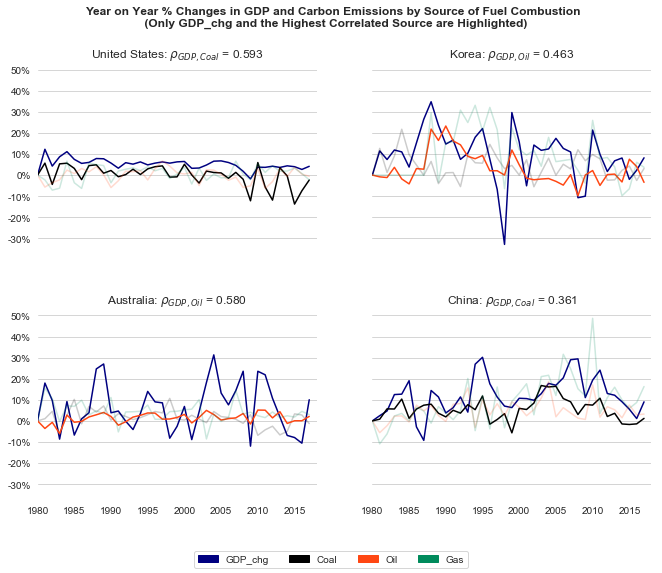

In [8]:
sns.set_style('white') #can set style with this line 
fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)
fig.set_size_inches(11,8)
axes = [ax[0,0], ax[1,0], ax[0,1], ax[1,1]]
color_dict = {
    'GDP_chg': color_converter(navy),
    'Coal': 'black',
    'Oil': color_converter(orange),
    'Gas': color_converter(green)
}

red_patch = mpatches.Patch(color='red', label='The red data')
blue_patch = mpatches.Patch(color='blue', label='The blue data')

countries = list(country_stats.keys())
for i in range(len(axes)):
    df = country_stats[countries[i]]
    country_data = list(country_stats[countries[i]].columns)
    axes[i].set_title(df.title)

    for j in country_data: #each j represents a column ['Country','Coal','Oil','Gas']
        axes[i].plot(df[j], label=j, color=color_dict[j])
    
    
    co2_types = df.columns[1:]
    correlations = []
    for co in df.columns[1:]:
        correlation = df[co].corr(df['GDP_chg'])
        correlations.append(correlation)

    max_idx = correlations.index(max(correlations))
    highest_corr_co2 = (co2_types[max_idx],max(correlations))
    rho_subscript = 'GDP, {}'.format(highest_corr_co2[0])
    corr_coeff = '{:.3f}'.format(highest_corr_co2[1])
    axes[i].set_title('{country}: {sym} = {corr}'.format(country=df.title, sym=r'$\rho_{'+rho_subscript+'}$', corr=corr_coeff))
    axes[i].yaxis.grid(True)
    axes[i].grid(which='minor', axis='y', alpha=0.2)

    #Remove spines
    remove_spines = ['right', 'top', 'bottom', 'left']
    for spine in remove_spines:
        axes[i].spines[spine].set_visible(False)
        
    #Set yticks for each subplot
    for label in axes[i].get_yticklabels() + axes[i].get_xticklabels():
        label.set_visible(True) 
    
    #Highlighting the source with the highest correlation to GDP
    lines = axes[i].get_lines()
    for line in lines:
        label = line.get_label()
        if label not in ['GDP_chg', highest_corr_co2[0]]:
            line.set_alpha(0.2)

handles = []
for k, v in color_dict.items():
    patch = mpatches.Patch(color=v, label=k)
    handles.append(patch)
labels = list(color_dict.keys())           
fig.legend(handles=handles, labels=labels, loc='lower center', ncol=4)
fig.suptitle('Year on Year % Changes in GDP and Carbon Emissions by Source of Fuel Combustion \n (Only GDP_chg and the Highest Correlated Source are Highlighted)', fontweight='bold')
axes[0].set_xlim(start,2018)

#Setting minor y ticks
minor_ticks = np.arange(-0.3, 0.3, 0.1)
axes[0].set_yticks(minor_ticks, minor=True)
vals = axes[0].get_yticks()
axes[0].set_yticklabels(["{:.0%}".format(x) for x in vals])

#Adjusts vertical space between subplots
plt.subplots_adjust(hspace=0.3)
